The MovieLens 1M dataset is used. My calculations involve machine learning techniques such as:
* Singular Value Decomposition (SVD)
* Matrix Factorization models
in order to predict the final user's rating on unrated movies (items).

Steps to do:
* build a user-item ratings matrix that is very sparse
* remove sparsity 
* normalize ratings per user -  get a normalized matrix
* make the normalized matrix factorization - get a low-rank approximation
* given matrices use to predict the recommendations for every user [1]

In [3]:
#!pip install surprise

In [4]:
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import re
from scipy.sparse.linalg import svds
from pandas.plotting import table
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

random.seed(2020)


# Pre-processing

Load data [2]

In [5]:
# folder 'data' consists files: ratings.dat, users.dat, movies.dat
movie_lens_dir = 'data'

In [6]:
ratings =pd.read_csv(os.path.join(movie_lens_dir,'ratings.dat'),
                     engine='python',
                     sep='::',
                     encoding='latin-1',
                     names=['user_id','movie_id','rating','timestamp'])
users =pd.read_csv(os.path.join(movie_lens_dir,'users.dat'),
                     engine='python',
                     sep='::',
                     encoding='latin-1',
                     names=['user_id','gender','age','occupation','zipcode'])
movies =pd.read_csv(os.path.join(movie_lens_dir,'movies.dat'),
                     engine='python',
                     sep='::',
                     encoding='latin-1',
                     names=['movie_id','title','genres'])

Info about dataframes

In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zipcode     6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


Merging dataframes

In [10]:
df_1 = pd.merge(ratings,movies, on='movie_id')

In [11]:
df = pd.merge(df_1,users, on='user_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1000209 non-null  int64 
 1   movie_id    1000209 non-null  int64 
 2   rating      1000209 non-null  int64 
 3   timestamp   1000209 non-null  int64 
 4   title       1000209 non-null  object
 5   genres      1000209 non-null  object
 6   gender      1000209 non-null  object
 7   age         1000209 non-null  int64 
 8   occupation  1000209 non-null  int64 
 9   zipcode     1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 83.9+ MB


In [12]:
df.sample(3)

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zipcode
935181,203,3051,1,976929525,Anywhere But Here (1999),Drama,F,18,4,53715
325792,4327,587,4,965243739,Ghost (1990),Comedy|Romance|Thriller,M,35,17,37221
468740,922,2728,4,975215617,Spartacus (1960),Drama,M,56,16,48009


Cleaning

In [18]:
# removing unused columns
df_2 = df.copy()
df_2.drop(columns=['timestamp','age','zipcode','occupation','gender'],inplace=True)

In [20]:
# separating a year from a movie title
df_2['movie_year']= df_2['title'].str.extract('(\d\d\d\d)', expand=True).astype(int) 

# Remove a year from a title
def remove_brackets(title):
    for x in title:
      re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", x)
    return re.sub(r" ?\([^)]+\)", "", title)
   

df_2['title'] = df_2['title'].map(remove_brackets)

In [21]:
# replace '|' with ',' in the genres column
df_2['genres'] = df_2['genres'].map(lambda x: str(x).replace('|',','))

# SVD algorithm [2, 3, 5]
* to obtain marices: U, S, V -> Scipy functions will be used
* U - Left Singular Vectors (matrix mxm)
* S - Singular Values (matrix mxn)
* V - Right Singular Vectors (matrix nxn)

In [22]:
# Merge movie_id, user_id and ratings in one table 
# Missing values take '0' value
ratings_pivot = df.pivot(index='user_id', columns='movie_id', values = 'rating').fillna(0)


In [23]:
# Noramlize data
rating_matrix = ratings_pivot.values
user_mean_rate = np.mean(rating_matrix, axis = 1)
rating_result = rating_matrix - user_mean_rate.reshape(-1, 1)

In [24]:
# Factorize the normalized matrix
# As a default rank k take 50
# After looking for k,the best k-factor is equal to 41 
U, sigma, Vt = svds(rating_result, k=41)
sigma = np.diag(sigma)

In [25]:
# Predict recommendation for any user
users_rating_predicted = np.dot(np.dot(U,sigma),Vt)  + user_mean_rate.reshape(-1,1)
predictions = pd.DataFrame(users_rating_predicted, columns = ratings_pivot.columns)
predictions.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,3.951004,0.270550,-0.147857,-0.027741,0.056927,-0.131927,-0.079163,0.171728,-0.038791,-0.188002,0.505100,-0.089275,0.356653,-0.008623,-0.055894,0.002028,0.291105,-0.004853,-0.100982,-0.055366,-0.240548,0.066536,0.021838,0.148771,0.137320,0.003089,0.074446,-0.117102,-0.028571,-0.009559,0.077475,0.367451,0.012838,2.534001,-0.028750,0.777772,0.033963,0.026482,0.085470,0.025392,...,0.024402,0.001118,-0.027737,0.254299,-0.124225,-0.088783,-0.024383,-0.042343,-0.009392,-0.026296,-0.026279,-0.013708,-0.076492,-0.025479,-0.002858,0.016148,0.001365,-0.090983,0.007198,-0.084933,0.011504,-0.000968,-0.004849,0.004037,-0.041013,0.005762,0.002253,0.012032,0.016180,0.014658,-0.014167,0.022218,0.041967,-0.016934,-0.092338,0.229737,0.014805,0.016189,0.017639,0.046999
1,1.001362,0.519169,0.199148,0.029538,0.020854,0.960121,-0.002345,0.065988,0.170455,1.462494,0.735969,0.009388,-0.042337,0.061303,0.125677,0.156395,0.998606,-0.128009,0.006235,0.247231,1.791643,-0.094498,0.019436,0.281119,0.648198,0.089964,0.016853,0.079555,-0.154543,0.021787,0.037482,0.584605,-0.006078,1.102033,-0.002287,1.142642,-0.014480,-0.032286,0.311877,0.092710,...,-0.045210,-0.109102,-0.073207,0.318604,0.016626,0.033124,0.003320,-0.103308,-0.030867,-0.040280,0.098660,-0.013736,-0.070923,0.131650,0.143838,0.130817,0.060069,0.108856,0.002978,0.097948,0.020118,0.012476,0.003368,0.152790,0.022127,0.006031,-0.001853,-0.000349,0.003514,0.009687,-0.040494,-0.015312,-0.010226,0.046758,-0.016772,0.098379,-0.374367,-0.084940,-0.047647,-0.148654
2,2.042067,0.687503,0.007794,0.002161,-0.073512,-0.244100,-0.224845,0.064652,0.068605,0.601857,0.067211,-0.021259,0.049743,0.038985,0.122532,-0.098259,-0.274372,0.091213,-0.007387,0.108525,0.323609,0.137694,0.120979,-0.160471,0.025915,-0.014813,0.037826,-0.125052,-0.082930,-0.078117,0.121073,-0.304817,-0.000134,1.095205,-0.085144,0.226408,-0.006355,-0.005161,0.371546,-0.011035,...,0.003331,-0.018106,0.034349,-0.181628,0.077786,0.033873,0.005226,-0.002977,-0.019649,-0.006145,-0.044510,-0.009605,0.136673,-0.116082,-0.121970,0.077063,0.125148,0.029670,-0.022769,-0.105246,-0.001034,-0.031956,-0.012466,0.107205,-0.022433,0.017847,0.013967,0.003083,0.008913,0.013038,0.009219,-0.001240,0.026868,0.020155,0.014505,-0.046882,-0.022562,-0.029519,0.005729,-0.169092
3,0.401655,-0.092040,-0.020559,0.083002,0.097942,0.315964,-0.017889,0.018294,0.035938,-0.042917,-0.338509,0.069346,0.006981,0.033106,-0.001355,-0.206942,0.094304,-0.073953,0.081081,0.066889,0.314686,-0.129685,-0.063671,-0.211239,0.198271,0.000095,0.035021,0.013388,-0.052988,-0.003619,0.018447,0.189091,-0.007218,0.030846,0.011329,0.127318,-0.012850,0.026572,-0.035630,-0.004249,...,-0.005338,0.013179,0.026816,-0.049460,-0.080457,-0.044399,-0.018422,-0.042294,0.007550,-0.014015,-0.027900,0.003020,-0.070947,-0.091150,-0.102308,0.000704,-0.099397,-0.034108,-0.019848,-0.058661,-0.007881,-0.029473,-0.003048,-0.041008,-0.115254,-0.012071,-0.005897,-0.004511,-0.009454,-0.005781,0.014128,0.003279,-0.006053,-0.014582,-0.068406,-0.041519,0.082592,-0.011050,0.017799,-0.054135
4,1.329970,0.025031,-0.014479,0.165289,-0.112080,1.402703,-0.208199,0.008782,-0.032893,0.612657,-0.428299,0.013641,-0.071282,0.246060,-0.027573,1.008273,1.355451,0.226146,-0.076987,-0.045467,2.043174,0.121833,-0.148394,0.615836,1.826567,0.148561,-0.056021,0.292403,1.007679,0.357789,-0.072162,2.202490,0.005503,2.007188,0.275373,1.646333,0.010697,-0.007087,1.222430,0.081453,...,0.059252,0.243346,0.174849,-0.309138,0.012960,-0.054518,-0.061133,0.128208,0.052691,0.039352,0.017703,0.029320,0.046459,0.059807,0.053507,0.035468,-0.180025,0.074060,0.018130,0.036480,0.018500,0.034105,0.028174,-0.032645,-0.066466,0.009300,0.0

## Model tuning - findng the best k-factor [4]

In [26]:
# Using Surprise library
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df_2[['user_id','movie_id','rating']],reader)

In [27]:
def find_k_factor(model, data):
  rmse_result = []
  
  for k in range(30, 50, 1):
    algorithm = model(n_factors = k)  
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=True)["test_rmse"].mean() 
    rmse_result.append(loss)
    print('k = {}'.format(k))
  return rmse_result

In [21]:
best_k = find_k_factor(SVD,data)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8712  0.8704  0.8701  0.8661  0.8726  0.8701  0.0022  
Fit time          19.27   19.79   19.83   19.96   19.93   19.76   0.25    
Test time         1.90    1.87    1.87    1.84    2.08    1.91    0.09    
k = 30
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8718  0.8691  0.8724  0.8704  0.8685  0.8705  0.0015  
Fit time          19.52   19.93   20.03   20.02   19.99   19.90   0.19    
Test time         1.84    2.06    1.87    1.83    1.84    1.89    0.08    
k = 31
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8714  0.8702  0.8729  0.8679  0.8716  0.8708  0.0017  
Fit time          19.85   20.43   20.31   20.35   20.43   20.27   0.22    
Test time     

Here the list: best_k was saved as a dataframe to avoid repeating finding the best k

In [82]:
df_best_k = pd.DataFrame(best_k)
#df_best_k.to_csv('/content/drive/My Drive/Colab Notebooks/Recommendation_system/output/best_k_factor.csv', index=False) 

In [28]:
def plot_best_k(best_k):
  x1 = np.arange(30,50,1)
  y1=np.array(best_k)  
  
  fig, ax = plt.subplots(figsize=(10,5))
  ax.plot(x1,y1)  

  def annot_min(x1,y1, ax=None):
      xmin = x1[np.argmin(y1)]
      ymin = y1.min()
      text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
      if not ax:
          ax=plt.gca()
      bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=1.72)
      arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=90")
      kw = dict(xycoords='data',textcoords="axes fraction",
                arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
      ax.annotate(text, xy=(xmin, ymin), xytext=(0.3,0.8), **kw)
  plt.ylabel('Mean RMSE (cv=5)',size = 15)
  plt.xlabel('k - factor',size = 15)
  plt.title("SVD algorithm: RMSE vs k=n_factor",  size = 15 )
  annot_min(x1,y1)
  ax.set_ylim(0.8698,0.8715)
  plt.show()

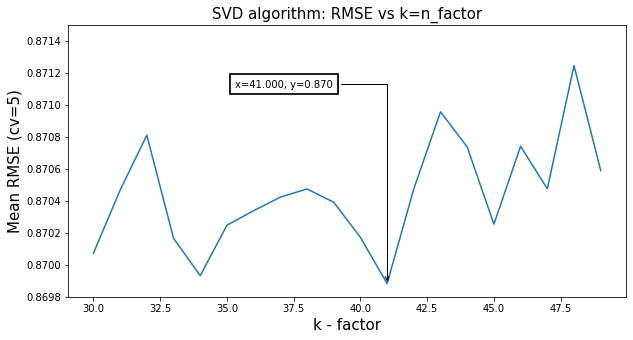

In [90]:
plot_best_k(best_k)

Comparing the result of the function:  plot_best_k with GridSearchCV (function from Surprise package).
The result is slightly different:
* for the function plot_best_k -> k=41 for RMSE = 0.8698 and where k=34 then RMSE = 0.8699
* for GridSearchCV the best k = 34 where RMSE = 0.8698. At this point other hyperparameters were calculated as well -> number of epochs, learning rate, regularization term for all parameters. I used them with k=41 in the evaluation model step.

In [27]:
param_grid = {'n_factors': [30,33,34,41],'n_epochs': [20,30], 'lr_all': [0.005,0.01],'reg_all':[0.02,0.1]}
gs= GridSearchCV(SVD,param_grid, measures=['rmse'],cv=5)
gs.fit(data)

#best rmse score
print(gs.best_score['rmse'])

# best params
print(gs.best_params['rmse'])

0.8698143714491978
{'n_factors': 34, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


In [31]:
# Build a function that returns n the best movie's recommendation for a given user 
def movie_recommender(df,predictions, user_id,num_recomds):
  """
  Arguments: df -> dataframe
             predictions -> dataframe created from factorized matrices
             user_id -> for what user_id recommendations are being done
             num_recomds -> how many movies should be recommended

  Return: a new dataframe with the best recommendations,
          a dataframe with already watched movies
  """
  if user_id in df['user_id'].unique():
     # user_id starts from 1, in predictions dataframe indexing starts from 0
     num_user = user_id -1
   
     # sort predictions for a user
     sorted_user_predictions = predictions.iloc[num_user].sort_values(ascending=False)
     
     # show what movies that user rated -> watched
     original_ratings = df[df['user_id']==user_id].sort_values(by='rating',ascending=False)
   
     # show unwatched movies
     recommendations = df[~df['movie_id'].isin(original_ratings['movie_id'])]
   
     # merge unwatched movies with the best prediction  
     result= pd.merge(recommendations,sorted_user_predictions, on='movie_id').rename(columns = {num_user: 'predictions'})
     result_new = result.drop_duplicates(['movie_id']).copy()
     result_new.sort_values(by='predictions', ascending=False,inplace=True)
     result_display=result_new[['movie_id','title', 'genres','movie_year','predictions']].copy()
     
     return original_ratings[['movie_id','rating','title','genres','movie_year']][:num_recomds], result_display.iloc[:num_recomds]
  else:
     print("Such user_id does not exist in the dataset!")
     

# Model evaluation by using Surprise package [3]

In [36]:
def svd_surprise_predictions(user_id,df,n_top):

    '''
    Arguments: user_id,
               dataframe -> df_2,
               n_top -> how many recommendations
    Return: dataframe with recommendations
    '''
    reader = Reader(rating_scale=(1, 5)) 
    data = Dataset.load_from_df(df_2[['user_id','movie_id','rating']],reader)
    trainset = data.build_full_trainset()
    testset = trainset.build_anti_testset()
    model = SVD(n_factors=41,n_epochs=20, lr_all = 0.005, reg_all= 0.02)
    model.fit(trainset)
  
    # link a movie's id with  a movie's id to a dictionary
    linked_movie = dict(zip(df.title.tolist(), df.movie_id.tolist()))

    if user_id in df['user_id'].unique():
        user_list = df[df['user_id'] == user_id].movie_id.tolist()
        linked_dict = {k: v for k,v in linked_movie.items() if not v in user_list}        
        predictions_list = []
        for i, j in linked_dict.items():     
            predicted = model.predict(user_id, j)
            predictions_list.append((i, predicted[3],predicted[1])) 
        df_3 = pd.DataFrame(predictions_list, columns = ['movies', 'ratings','movie_id'])
      
        df_4 = pd.merge(df_3,df_2,on='movie_id')
        df_4.drop(columns=['user_id','title'],inplace=True)
        df_4.drop_duplicates(['movie_id'],inplace=True)
        df_4.sort_values('ratings', ascending=False, inplace=True)
        return df_4.iloc[:n_top]        
    else:
        print("Such user_id does not exist in the dataset!")
        

## Recommendations

In [32]:
watched_movies, recommended_movies = movie_recommender(df_2,predictions,2000,10)

In [33]:
# Movies already watched by user
watched_movies

,movie_id,rating,title,genres,movie_year
155333,1193,5,One Flew Over the Cuckoo's Nest,Drama,1975
155373,1136,5,Monty Python and the Holy Grail,Comedy,1974
155396,1688,5,Anastasia,"Animation,Children's,Musical",1997
155358,2858,5,American Beauty,"Comedy,Drama",1999
155356,110,5,Braveheart,"Action,Drama,War",1995
155367,2501,5,October Sky,Drama,1999
155353,1259,5,Stand by Me,"Adventure,Comedy,Drama",1986
155408,2529,5,Planet of the Apes,"Action,Sci-Fi",1968
155369,318,5,"Shawshank Redemption, The",Drama,1994
155349,2028,5,Saving Private Ryan,"Action,Drama,War",1998


In [34]:
# Recommended movies with the Scipy functions
recommended_movies

,movie_id,title,genres,movie_year,predictions
28396,3114,Toy Story 2,"Animation,Children's,Comedy",1999,3.491961
62633,589,Terminator 2: Judgment Day,"Action,Sci-Fi,Thriller",1991,2.721535
149688,2959,Fight Club,Drama,1999,2.430128
142953,296,Pulp Fiction,"Crime,Drama",1994,2.142574
20434,588,Aladdin,"Animation,Children's,Comedy,Musical",1992,2.111063
112661,356,Forrest Gump,"Comedy,Romance,War",1994,2.041462
74063,1265,Groundhog Day,"Comedy,Romance",1993,2.037527
29981,608,Fargo,"Crime,Drama,Thriller",1996,1.987296
236774,223,Clerks,Comedy,1994,1.960353
98402,457,"Fugitive, The","Action,Thriller",1993,1.899159


In [37]:
# Predicted movies with the Surprise functions
predicted_movies =svd_surprise_predictions(100,df_2,10)
predicted_movies

,movies,ratings,movie_id,rating,genres,movie_year
831800,Sanjuro,4.166793,2905,4,"Action,Adventure",1962
827600,"General, The",4.157221,3022,5,Comedy,1927
492343,Singin' in the Rain,4.061139,899,3,"Musical,Romance",1952
18586,Wallace & Gromit: The Best of Aardman Animation,3.960437,720,3,Animation,1996
397655,Seven Samurai,3.960133,2019,5,"Action,Drama",1954
415483,"Wrong Trousers, The",3.957712,1148,4,"Animation,Comedy",1993
863627,For All Mankind,3.932761,3338,4,Documentary,1989
672514,Sunset Blvd.,3.914717,922,5,Film-Noir,1950
746659,Paths of Glory,3.904589,1178,5,"Drama,War",1957
504391,North by Northwest,3.903683,908,5,"Drama,Thriller",1959


## Results comparison

In [38]:
def count_genre(df):
  '''
  Argument: dataframe
  Return: dataframe where every genre was counted and its percentage value
  '''
  genress = pd.DataFrame(df.genres.str.split(',', expand=True).stack(), columns= ['genres'])  
  genress = genress.reset_index(drop = True)  
  genre_count = pd.DataFrame(genress.groupby(by = ['genres']).size(),columns = ['count'])  
  genre_count = genre_count.reset_index()
  genre_count['percent %'] = round((genre_count['count'] / 
                  genre_count['count'].sum()) * 100,2)
  return genre_count

In [58]:
def plot_pie(df_genres,title):
  '''
  Argument: dataframe received from the function 'count_genre'
  Output: pie diagram with a table below with percentage values of the most favouritegenre 
  '''
  plt.figure(figsize=(8,6))
  labels = df_genres['genres']
  plt.pie(df_genres['percent %'], labels=labels)
  plt.table(cellText=[df_genres['percent %']], colLabels=labels,colWidths=[0.3 for x in labels],bbox=[0.0, -0.3, 2.0 , 0.3], cellLoc='center',rowLabels=["percent %"])
  plt.title(title)
  


In [59]:
def compare_genre(watched_movies, recommended_movies,predicted_movies):
  '''
  Arguments: dataframes received from the functions:
            * movie_recommender -> watched_movies, recommended_movies
            * svd_suprise_predictions -> predicted_movies
  Return: 3 pie charts with tables
  '''
  x = count_genre(watched_movies)
  y = count_genre(recommended_movies)
  z = count_genre(predicted_movies)
  return plot_pie(x,"Watched movies"),plot_pie(y, "Recommended movies (Scipy)"),plot_pie(z,'Predicted movies (Surprise)')

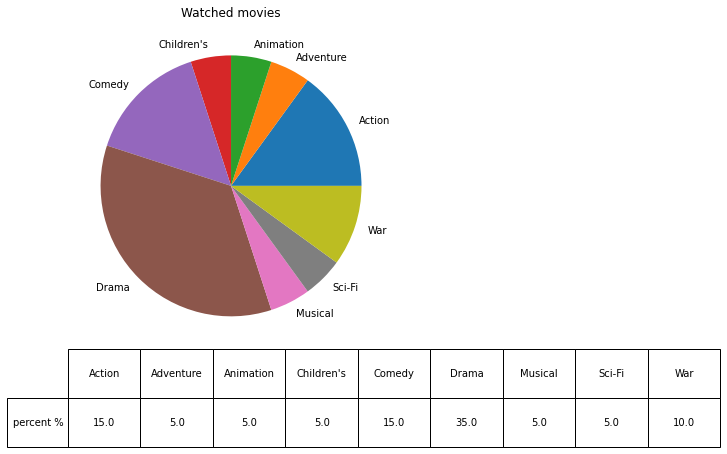

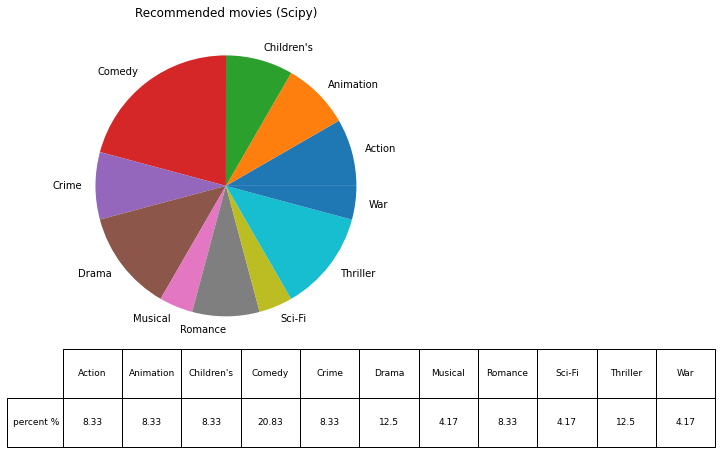

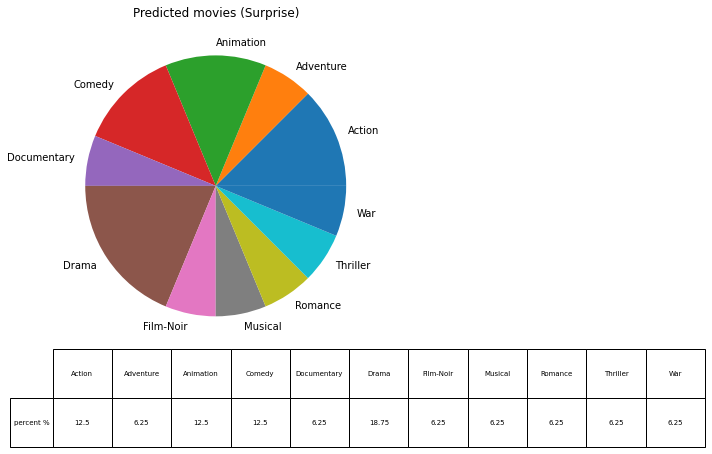

In [60]:
compare_genre(watched_movies,recommended_movies,predicted_movies);

# Conclusion

The notebook shows how to build an easy movie recommendation system with MovieLens 1M dataset. The system is an example of Model-Based Collaborative Filtering. There is a solution based on the model factorization using functions (as svds) from the Scipy package.To obtain the best k-factor used: function based on the cross-validation method with iterated k-factor and the GridSearchCV function. Both calculated the mean score on the 5-fold cross-validated dataset and involved Root Mean Square Error (RMSE) metric.
Finally, to evaluate the results, a comparison was made between: watched movies, recommended movies(Scipy) and predicted movies(Surprise). The comparison concerned the movie genre. For example, if a user liked comedies, dramas or action movies, it was expected to receive a similar genre in recommended movies and predicted movies. To maked results clearer,the percentages for the most liked genre are listed in the table below each pie chart.

References:

---


[1] https://stanford.edu/~rezab/classes/cme323/S16/projects_reports/baalbaki.pdf

[2] https://github.com/khanhnamle1994/movielens/blob/master/SVD_Model.ipynb


[3] https://blog.codecentric.de/en/2019/07/recommender-system-movie-lens-dataset/

[4] https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919

[5] https://www.analyticsvidhya.com/blog/2019/08/5-applications-singular-value-decomposition-svd-data-science/